#Part 1: Setup

In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 568.8 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_6

In [3]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.4 which is incompatible.


In [16]:
from ultralytics import YOLO
import mediapipe as mp
import cv2
import os
import glob
from google.colab.patches import cv2_imshow

#Part 2: Extract landmarks from raw images

##2.1. Define functions

In [105]:
def extract_landmarks(image_path, yolo_result, num_faces=1, num_landmarks=468, plot=False):
  """
  Extracts facial landmarks from YOLO detection results using MediaPipe.

  Inputs:
    image_path (str): Path to the input image.
    yolo_result (YOLO): Result object from a YOLO face detection model.
    num_faces (int, optional): Number of faces to process. Defaults to 1.
    num_landmarks (int, optional): Number of landmarks to extract per face. Defaults to 468.
    plot (bool, optional): Whether to plot the detected faces and landmarks. Defaults to False.

  Outputs:
    faces_list (list): a list of faces containing (x, y) landmarks coordinates for each detected face.

  """
  # Read image
  image = cv2.imread(image_path)

  # Get bounding box coordinates of all detected faces
  boxes = yolo_result.boxes.xyxy.tolist()
  # Plot original image with all bounding boxes
  if plot==True:
    annotated_frame = yolo_result.plot()
    im1 = cv2.resize(annotated_frame, (500, 500))
    cv2_imshow(im1)

  # Extract only a limited number of faces
  if num_faces > len(boxes):
    num_faces = len(boxes)

  faces_list = []
  for i, box in enumerate(boxes[:num_faces]):
    tl_x = int(box[0])
    tl_y = int(box[1])
    br_x = int(box[2])
    br_y = int(box[3])

    # Segmentate the original image to only 1 detected face
    cropped_face = image[tl_y:br_y, tl_x:br_x]
    cropped_face_rgb = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)

    # Initialize MediaPipe Face Mesh
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh()

    # Facial landmarks
    landmarks = face_mesh.process(cropped_face_rgb)

    # Check if landmarks were detected on the segmentation
    if landmarks.multi_face_landmarks:
      # Extract landmarks coordinates for the current face
      landmarks_coords = []
      for facial_landmarks in landmarks.multi_face_landmarks:
        # Limit landmarks to the specified number
        for i in range(0, num_landmarks):
          pt1 = facial_landmarks.landmark[i]
          x = int(pt1.x * cropped_face.shape[1])
          y = int(pt1.y * cropped_face.shape[0])

          landmarks_coords.append((x, y))
          cv2.circle(cropped_face, (x, y), 3, (100, 100, 0), -1)

      # Append landmarks of the current face to the main list
      faces_list.append(landmarks_coords)

    else:
      print(f'Warning: No facial landmarks detected for face {i+1} in image {image_path}')

    # Plot the segmentation with landmarks
    if plot==True:
      im2 = cv2.resize(cropped_face, (500, 500))
      cv2_imshow(im2)

  return faces_list



def landmarks_of_all_images(dataset_path, detect_model_path, num_img: int(), num_faces: int(), num_landmarks: int(), plot=False):
  """
  Extracts facial landmarks from a set of images using YOLO for face detection and MediaPipe for landmark extraction.

  Inputs:
    dataset_path (str): Path to the directory containing images.
    detect_model_path (str): Path to the YOLO face detection model.
    num_img (int): Number of images to process.
    num_faces (int): Number of faces to detect per image.
    num_landmarks (int): Number of landmarks to extract per face.
    plot (bool): Whether to plot detected faces and landmarks (default: False).

  Outputs:
    imgs_list (list): a list of images containing (x, y) landmarks coordinates for each detected face on each image.

  """

  # Create a list of image paths
  image_paths = []
  for image_path in glob.glob(dataset_path+'/*.jpg'):
    image_paths.append(image_path)

  # Limit processing to the specified number of images
  if num_img > len(image_paths):
    num_img = len(image_paths)
  image_paths = image_paths[:num_img]

  # Initiate Face detection model
  model = YOLO(detect_model_path)
  img_results = model(image_paths)
  imgs_list = []

  # Integrate through each image
  for idx, img_result in enumerate(img_results):
    faces_list = extract_landmarks(image_paths[idx], img_result, num_faces=num_faces, num_landmarks=num_landmarks, plot=plot)
    imgs_list.append(faces_list)

  return imgs_list


##2.2. Test function


0: 640x640 2 faces, 215.2ms
1: 640x640 2 faces, 215.2ms
Speed: 6.1ms preprocess, 215.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


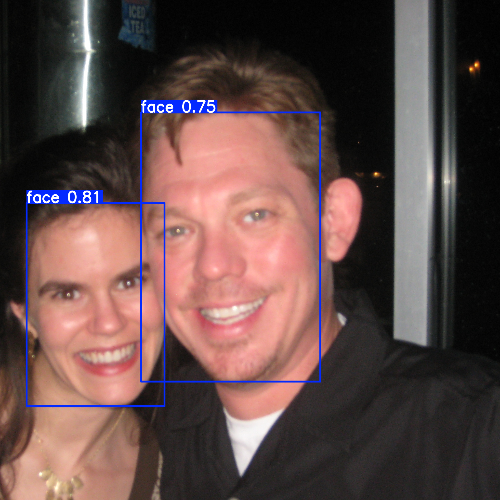

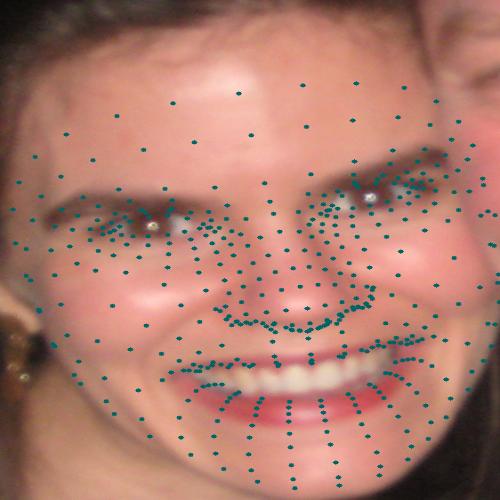

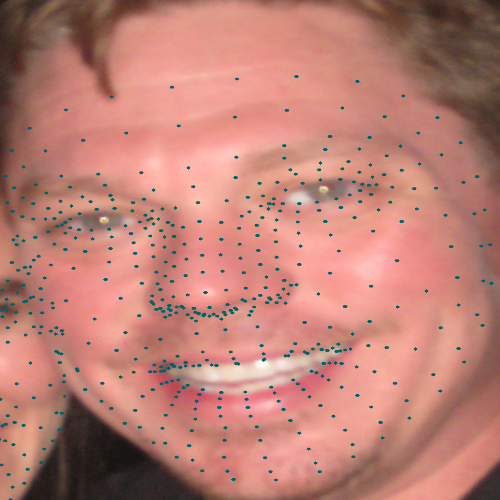

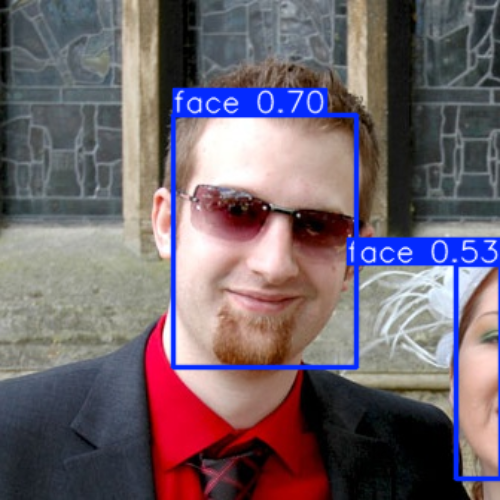

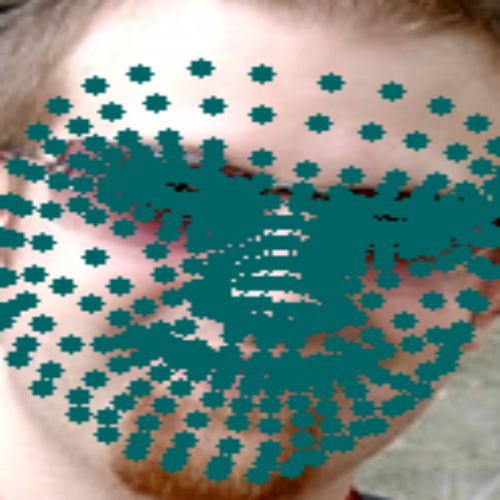

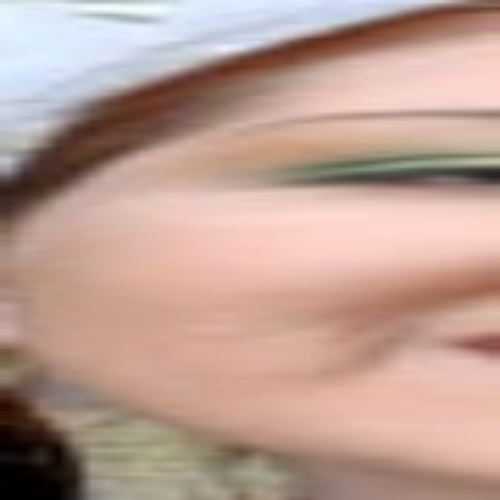

In [106]:
# Read testing image folder and YOLO8 detection model paths
dataset_path = "/content/drive/MyDrive/ComputerVision/Facial Recognition/images"
detect_model_path = "/content/drive/MyDrive/ComputerVision/Facial Recognition/yolov8n-face.pt"

# Define parameters
num_images = 2
num_faces = 2
num_landmarks = 468

# Extract landmarks for images in the dataset
landmarks_list = landmarks_of_all_images(dataset_path, detect_model_path, num_images, num_faces, num_landmarks, plot=True)

In [107]:
# Print the extracted landmarks
for i, landmarks in enumerate(landmarks_list):
  print(f"Landmarks for image {i+1}:")
  for face_landmarks in landmarks:
    print(face_landmarks)

Landmarks for image 1:
[(349, 554), (348, 505), (345, 518), (309, 425), (345, 482), (337, 448), (314, 362), (136, 367), (303, 315), (297, 286), (268, 146), (350, 563), (350, 568), (349, 566), (360, 626), (361, 635), (363, 645), (365, 657), (367, 675), (349, 515), (321, 512), (21, 285), (214, 374), (190, 380), (166, 383), (126, 375), (231, 368), (163, 332), (190, 329), (140, 339), (125, 348), (110, 392), (279, 710), (123, 363), (29, 389), (78, 385), (203, 477), (308, 557), (312, 572), (266, 562), (239, 566), (280, 573), (256, 574), (220, 611), (328, 508), (321, 485), (87, 337), (247, 413), (257, 494), (253, 479), (126, 478), (316, 453), (145, 314), (110, 322), (39, 245), (255, 321), (214, 332), (192, 582), (90, 600), (276, 504), (299, 510), (206, 579), (220, 580), (93, 308), (254, 499), (193, 313), (185, 295), (131, 181), (68, 276), (161, 234), (69, 327), (46, 307), (310, 567), (274, 570), (248, 570), (281, 506), (212, 579), (234, 602), (224, 580), (295, 505), (259, 570), (284, 570), (3

#Part 3: Extract landmarks from segmented images (after detection)

##3.1. Define functions

In [108]:
def extract_segmented_landmarks(image_path, num_landmarks=468, plot=False):
  """
  Extracts facial landmarks from a segmented face image using MediaPipe.

  Inputs:
    image_path (str): Path to the segmented face image.
    num_landmarks (int, optional): Number of landmarks to extract per face. Defaults to 468.
    plot (bool, optional): Whether to plot the detected faces and landmarks. Defaults to False.

  Outputs:
    landmarks_coords (list): A list of (x, y) landmarks coordinates for the detected face.

  """
  # Read image
  image = cv2.imread(image_path)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Initialize MediaPipe Face Mesh
  mp_face_mesh = mp.solutions.face_mesh
  face_mesh = mp_face_mesh.FaceMesh()

  # Facial landmarks
  landmarks = face_mesh.process(image_rgb)

  landmarks_coords = []
  # Check if landmarks were detected on the segmentation
  if landmarks.multi_face_landmarks:
    # Extract landmarks coordinates for the current face
    for facial_landmarks in landmarks.multi_face_landmarks:
      # Limit landmarks to the specified number
      for i in range(0, num_landmarks):
        pt1 = facial_landmarks.landmark[i]
        x = int(pt1.x * image.shape[1])
        y = int(pt1.y * image.shape[0])

        landmarks_coords.append((x, y))
        cv2.circle(image, (x, y), 1, (100, 100, 0), -1)

  else:
    print(f'Warning: No facial landmarks detected for image {image_path}')

  # Plot the segmentation with landmarks
  if plot==True:
    im2 = cv2.resize(image, (500, 500))
    cv2_imshow(im2)

  return landmarks_coords



def landmarks_of_segmented_images(dataset_path, num_img: int(), num_landmarks: int(), plot=False):
  """
  Extracts facial landmarks from a set of segmented face images.

  Inputs:
    dataset_path (str): Path to the directory containing segmented face images.
    num_img (int): Number of images to process.
    num_landmarks (int): Number of landmarks to extract per face.
    plot (bool): Whether to plot detected faces and landmarks (default: False).

  Outputs:
    imgs_list (list): a list of 1-face images containing (x, y) landmarks coordinates of the face.

  """

  # Create a list of image paths
  imgs_list = []
  for image_path in glob.glob(dataset_path+'/*.jpg'):
    if len(imgs_list) < num_img:
      landmarks_coords = extract_segmented_landmarks(image_path, num_landmarks=num_landmarks, plot=plot)
      imgs_list.append(landmarks_coords)
    else:
      break

  return imgs_list

##3.2. Test function

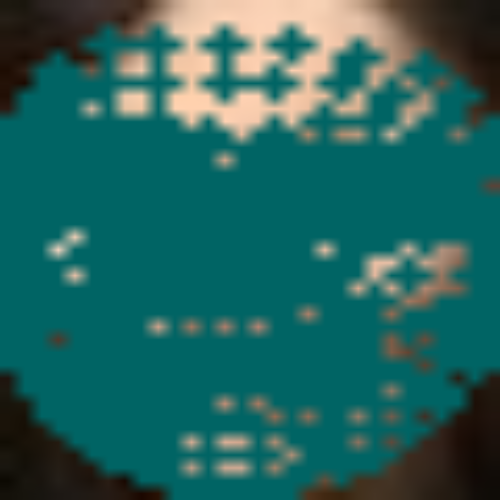

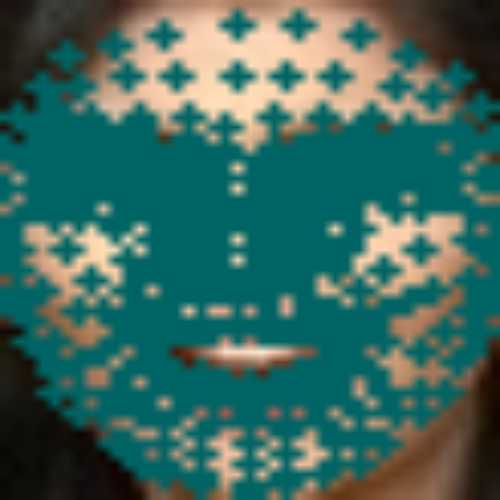

In [109]:
# Read testing image folder and YOLO8 detection model paths
dataset_path = "/content/drive/MyDrive/ComputerVision/Facial Recognition/predicts"

# Define parameters
num_images = 2
num_landmarks = 468

# Extract landmarks for images in the dataset
landmarks_list = landmarks_of_segmented_images(dataset_path, num_images, num_landmarks, plot=True)

In [110]:
# Print the extracted landmarks
for i, landmarks in enumerate(landmarks_list):
  print(f"Landmarks for image {i+1}:")
  print(landmarks)

Landmarks for image 1:
[(12, 26), (11, 22), (12, 24), (10, 18), (11, 21), (11, 19), (12, 15), (4, 14), (12, 11), (12, 10), (13, 3), (12, 27), (12, 27), (12, 27), (12, 28), (12, 28), (12, 29), (12, 30), (12, 32), (11, 23), (10, 23), (1, 9), (7, 15), (6, 15), (5, 15), (3, 15), (8, 15), (5, 12), (7, 12), (4, 12), (3, 13), (2, 15), (7, 34), (3, 14), (0, 15), (1, 15), (5, 20), (10, 26), (10, 27), (8, 26), (7, 26), (9, 27), (8, 27), (6, 28), (10, 22), (10, 21), (2, 11), (8, 17), (7, 21), (7, 21), (2, 20), (10, 19), (4, 10), (3, 10), (2, 7), (10, 11), (8, 13), (5, 27), (1, 27), (8, 22), (9, 23), (6, 27), (7, 27), (2, 9), (7, 22), (7, 10), (6, 9), (6, 3), (2, 8), (6, 6), (1, 11), (1, 10), (10, 27), (9, 27), (7, 27), (8, 23), (6, 27), (7, 27), (7, 27), (9, 22), (8, 27), (9, 27), (11, 27), (10, 31), (10, 30), (10, 29), (10, 28), (11, 28), (8, 27), (8, 27), (8, 28), (8, 28), (6, 25), (1, 21), (11, 23), (8, 27), (7, 27), (10, 23), (8, 23), (10, 23), (7, 18), (5, 19), (7, 21), (3, 5), (4, 7), (4, 9